Inserisci il percorso del file Excel per il portafoglio:  C:\Users\Mattia\Desktop\Task2 Risk Assessment Portfolio\Returns.xlsx
Inserisci il percorso del file Excel per il benchmark:  C:\Users\Mattia\Desktop\Task2 Risk Assessment Portfolio\MSCI World Historical Data.xlsx
Inserisci il capitale inizialmente investito:  10000
Vuoi investire tutto il capitale? (si/no):  no
Inserisci la percentuale di capitale da mantenere in liquidità (es. 0.2 per 20%):  0.25


Il capitale investito negli asset sarà 75.00% e la liquidità 25.00%.

Colonne trovate nel file:
Index(['TSM', 'AMZN', 'NVDA', 'BRK.B', 'REY', 'STLAM'], dtype='object')


Inserisci la percentuale di allocazione per TSM (es. 0.2 per 20%):  0.15
Inserisci la percentuale di allocazione per AMZN (es. 0.2 per 20%):  0.2
Inserisci la percentuale di allocazione per NVDA (es. 0.2 per 20%):  0.2
Inserisci la percentuale di allocazione per BRK.B (es. 0.2 per 20%):  0.05
Inserisci la percentuale di allocazione per REY (es. 0.2 per 20%):  0.1
Inserisci la percentuale di allocazione per STLAM (es. 0.2 per 20%):  0.05



Performance Summary
Metric                    Portfolio       Benchmark      
Start Balance             10000.0         10000.0        
End Balance               146176.88       95637.52       
CAGR (%)                  30.86%          25.41%         
Volatility (%)            18.55%          31.82%         
Sharpe Ratio              1.66            0.80           
Sortino Ratio             2.14            1.33           
Max Drawdown (%)          -35.77%         -57.11%        
Best Year (%)             63.97%          100.56%        
Worst Year (%)            12.38%          5.31%          
Benchmark Correlation     0.74            1.00           


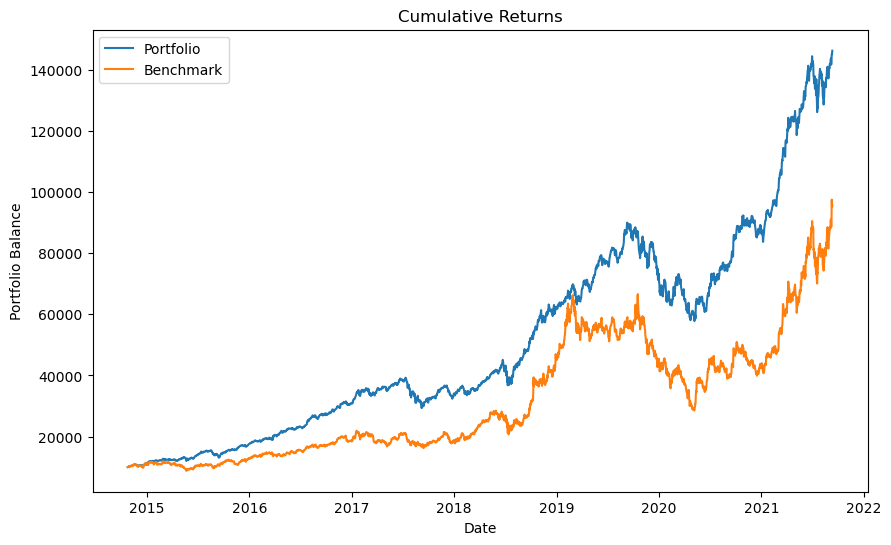

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(portfolio_file, benchmark_file):
    # Carica i dati dal file Excel
    portfolio_returns = pd.read_excel(portfolio_file, sheet_name=0)
    benchmark_returns = pd.read_excel(benchmark_file, sheet_name=0)
    
    # Assicurati che la prima colonna sia la data e la imposta come indice
    portfolio_returns.iloc[:, 0] = pd.to_datetime(portfolio_returns.iloc[:, 0])
    portfolio_returns.set_index(portfolio_returns.columns[0], inplace=True)
    
    benchmark_returns.iloc[:, 0] = pd.to_datetime(benchmark_returns.iloc[:, 0])
    benchmark_returns.set_index(benchmark_returns.columns[0], inplace=True)
    
    # Seleziona la colonna corretta (la seconda) e converti i valori percentuali del benchmark in decimali
    benchmark_returns = benchmark_returns.iloc[:, 0] 
    
    return portfolio_returns, benchmark_returns.squeeze()

def calculate_portfolio_metrics(returns, weights, benchmark_returns, initial_capital):
    """
    Calcola le metriche di performance del portafoglio.
    """
    # Calcola i rendimenti del portafoglio
    portfolio_daily = returns.dot(weights)
    cumulative_returns = (1 + portfolio_daily).cumprod()

    # Metriche chiave
    start_balance = initial_capital
    end_balance = start_balance * cumulative_returns.iloc[-1]
    cagr = (cumulative_returns.iloc[-1] ** (252 / len(portfolio_daily))) - 1
    volatility = portfolio_daily.std() * np.sqrt(252)
    sharpe_ratio = (cagr - 0) / volatility  # Rf=0
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    best_year = portfolio_daily.resample('YE').sum().max()
    worst_year = portfolio_daily.resample('YE').sum().min()
    sortino_ratio = calculate_sortino_ratio(portfolio_daily)
    benchmark_corr = portfolio_daily.corr(benchmark_returns)

    return {
        'Start Balance': round(start_balance, 2),
        'End Balance': round(end_balance, 2),
        'CAGR (%)': round(cagr * 100, 2),
        'Volatility (%)': round(volatility * 100, 2),
        'Sharpe Ratio': round(sharpe_ratio, 2),
        'Sortino Ratio': round(sortino_ratio, 2),
        'Max Drawdown (%)': round(max_drawdown * 100, 2),
        'Best Year (%)': round(best_year * 100, 2),
        'Worst Year (%)': round(worst_year * 100, 2),
        'Benchmark Correlation': round(benchmark_corr, 2)
    }, portfolio_daily

def calculate_max_drawdown(cumulative_returns):
    """
    Calcola il massimo drawdown.
    """
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    return drawdown.min()

def calculate_sortino_ratio(returns, target=0):
    """
    Calcola il Sortino Ratio con target return (default=0).
    """
    downside_returns = returns[returns < target]
    downside_std = downside_returns.std() * np.sqrt(252)
    expected_return = returns.mean() * 252
    if downside_std == 0:
        return np.nan
    return (expected_return - target) / downside_std

def display_summary(portfolio_metrics, benchmark_metrics):
    """
    Stampa un confronto delle metriche tra il portafoglio e il benchmark.
    """
    print("\nPerformance Summary")
    print(f"{'Metric':<25} {'Portfolio':<15} {'Benchmark':<15}")
    for key in portfolio_metrics:
        benchmark_value = benchmark_metrics.get(key, 'N/A')
        if isinstance(benchmark_value, (float, int)) and 'Balance' not in key:
            benchmark_value = f"{benchmark_value:.2f}%" if 'CAGR' in key or 'Volatility' in key or 'Max Drawdown' in key or 'Year' in key else f"{benchmark_value:.2f}"
        portfolio_value = portfolio_metrics[key]
        if isinstance(portfolio_value, (float, int)) and 'Balance' not in key:
            portfolio_value = f"{portfolio_value:.2f}%" if 'CAGR' in key or 'Volatility' in key or 'Max Drawdown' in key or 'Year' in key else f"{portfolio_value:.2f}"
        print(f"{key:<25} {portfolio_value:<15} {benchmark_value:<15}")

def main():
    # Input file
    portfolio_file = input("Inserisci il percorso del file Excel per il portafoglio: ")
    benchmark_file = input("Inserisci il percorso del file Excel per il benchmark: ")
    initial_capital = float(input("Inserisci il capitale inizialmente investito: "))

    # Carica i dati
    portfolio_returns, benchmark_returns = load_data(portfolio_file, benchmark_file)

    # Assicura che benchmark_returns sia una serie numerica corretta
    benchmark_returns = pd.to_numeric(benchmark_returns, errors='coerce').fillna(0)

    # Chiedi se tutto il capitale viene investito
    invest_all = input("Vuoi investire tutto il capitale? (si/no): ").strip().lower()
    liquidity = 0.0

    if invest_all == "no":
        liquidity = float(input("Inserisci la percentuale di capitale da mantenere in liquidità (es. 0.2 per 20%): "))
        asset_allocation = 1 - liquidity
        print(f"Il capitale investito negli asset sarà {asset_allocation * 100:.2f}% e la liquidità {liquidity * 100:.2f}%.")
    else:
        asset_allocation = 1.0

    # Input per le allocazioni
    print("\nColonne trovate nel file:")
    print(portfolio_returns.columns)
    weights = []
    for col in portfolio_returns.columns:
        weight = float(input(f"Inserisci la percentuale di allocazione per {col} (es. 0.2 per 20%): "))
        weights.append(weight)
    weights = np.array(weights)

    # Normalizza i pesi per sommare a asset_allocation
    weights /= weights.sum()
    weights = weights * asset_allocation

    # Aggiungi la liquidità come parte dei rendimenti (liquidità ha rendimento 0)
    portfolio_returns['Liquidity'] = 0.0
    weights = np.append(weights, liquidity)

    # Calcola le metriche
    portfolio_metrics, portfolio_daily = calculate_portfolio_metrics(portfolio_returns, weights, benchmark_returns, initial_capital)
    benchmark_metrics, benchmark_daily = calculate_portfolio_metrics(benchmark_returns.to_frame(), np.array([1.0]), benchmark_returns, initial_capital)

    # Stampa il confronto
    display_summary(portfolio_metrics, benchmark_metrics)

    # Calcola rendimenti cumulati con capitale iniziale
    portfolio_cumulative = initial_capital * (1 + portfolio_daily).cumprod()
    benchmark_cumulative = initial_capital * (1 + benchmark_daily).cumprod()

    # Visualizza i rendimenti cumulati
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_cumulative.index, portfolio_cumulative, label="Portfolio")
    plt.plot(benchmark_cumulative.index, benchmark_cumulative, label="Benchmark")
    plt.legend()
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Balance")
    plt.show()

if __name__ == "__main__":
    main()
